## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IIII - Conclusions](#Conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#using the seed to make sure that we get the same answers on quizzes as we did
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#We read data from the Excel fiels using pandas lib
df = pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
#we will use shapr function to know the number of rows and We will use info fuction to get information about everything at the data set
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
#We will define a variable and make it equal to the num of unique users using nunique fuction and then we will call it
num_unique = df['user_id'].nunique()
num_unique

290584

d. The proportion of users converted.

In [5]:
#The proportions of user who converted 
df[df.converted == 1].user_id.count()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#First we will get the number which landing_page equals to new_page but group is not treatment
#Seconde we will get the number which landing_page not equals to new_page but group is treatment
#Then we will add them together and we will get our result
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

f. Do any of the rows have missing values?

In [7]:
#Having missing valuses mean that we have null values then we will use isnull fuction
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#We will do the same thing that we did at point e 
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#info Function will give us all information we need and then we will see the unique users
df2.info()
df2.user_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#we will use duplicated function
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
#we will put it in a data frame and see it
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#we will use timestamp function
df2 = df2[df2.timestamp != '2017-01-09 05:37:58.781806']

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#we will use the converted data frame and take the mean for control row
df2.converted[df2.group == 'control'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#Same as b point
df2.converted[df2.group == 'treatment'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[df2.landing_page == 'new_page'].count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
#it means the number of converted users
new_p = df2.converted.mean()
new_p

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
#same as a point
old_p = df2.converted.mean()
old_p

0.11959708724499628

c. What is $n_{new}$?

In [20]:
#it means the number of  users who get new page
new_n = df2[df2.group == 'treatment'].count()[0]
new_n

145310

d. What is $n_{old}$?

In [21]:
#it means the number of  users who still use the old page
old_n = df2[df2.group == 'control'].count()[0]
old_n

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1,new_p,new_n) 
new_page_converted.mean()

0.12024636983001859

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1,old_p,old_n)
old_page_converted.mean()

0.12156339055853077

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_p = new_page_converted.mean()
old_p = old_page_converted.mean()
new_p - old_p

-0.0013170207285121832

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,new_p,new_n)  # bootstrapping
    old_page_converted = np.random.binomial(1,old_p,old_n) # bootstrapping
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

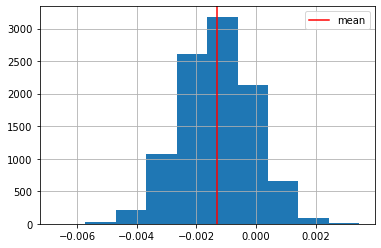

In [26]:
#we will convert it for array based computations and then we will do our histogram
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.grid()
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
real_diff = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(real_diff < p_diffs).mean()

0.5861

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We calculated P-value and it is the probability of observing the statistics if the null hypothesis is true---- p-value is so big so that we fail to reject null hypothesis.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum() 
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

# z-score represents how many standard deviations away our data point is from the mean
# A positive z-score suggests that our data point is on the right side of the mean line on the bell curve
# p-value of 0.9050 is very close to the p-value we computed earlier in part j.
# With this computation, we can confidently say we fail to reject null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

This is a case of Logistic Regression. In this scenario, we want to predict something that has only two possible outcomes.


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
#we will add intercept
df2['intercept'] = 1

# using get_dummies fun to convert the landing_page and group to 1 and 0
df2[['landing_page_new', 'landing_page_old']] = pd.get_dummies(df2['landing_page'])
df2[['ab_page_control','ab_page_treatment']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page_treatment']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Jun 2021   Pseudo R-squ.:               8.077e-06
Time:                        06:04:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007
=====================================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

# The logistic regression is two-tailed case. We are exploring only two possible outcomes and it can go either way
# The null and alternative hypothesis associated with regression model will be as following:$$ H_{0}: old_p - new_p = 0$$$$ H_{0}:  old_p - new_p \neq 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

# There can be many other factors that can be taken into consideration to add into our regression model.

One of the first to consider would be the duration. The duration of this experiment was 21 days. Too short, it would be advisable to increase the duration
Geographic location is another important factor. If the page is available in multiple languages, for example, it can diversify the sample
Parameters like click through rate is another factor to consider

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
### Create the necessary dummy variables
df_new[['canada','uk','us']] = pd.get_dummies(df_new['country'])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','canada','uk']])
results = logit_mod.fit()

results.summary()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Jun 2021   Pseudo R-squ.:               1.521e-05
Time:                        06:04:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
canada        -0.0408      0.027     -1.518      0.129      -0.093       0.012
uk             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

at this project, we use the following to  understand that the company should implement a new page or keep the old page :

Probability based approach
A/B test
Regression approach
### Probability based approach:
We found that there is almost the same chance that an individual received the old page using probability of an individual receiving the new page
### A/B test:

In A/B test we set up our hypothesis to test if new page results in better conversion or not.